In [7]:
import math
import pandas as pd
from IPython.display import Image, display

from hmcollab import datasets
from hmcollab import articles
from hmcollab import transactions

In [2]:
dataset = datasets.HMDataset()

In [6]:
customer_ids = dataset.transactions.customer_id.unique()
customer_ids.shape   # (1362281,)

(1362281,)

In [9]:
features = [
        "product_type_no",
        "product_group_name",
        "graphical_appearance_no",
        "colour_group_code",
        "perceived_colour_value_id",
        "perceived_colour_master_id",
        "department_no",
        "index_code",
        "index_group_no",
        "section_no",
        "garment_group_no",
        ]

In [10]:
def dummy_features(df, columns):
    # for articles
    return pd.get_dummies(df[['article_id'] + columns], columns=columns, prefix=columns)

dummies = dummy_features(dataset.articles, features)

In [13]:
simple_munger = articles.ArticleFeaturesSimpleFeatures(dataset.articles)
model = articles.ArticleKNN(simple_munger, k=6)

In [17]:
def recommender_by_customer(customer, groups=6, total_recommendations=12):
    """
        customer:
            The customer id
        groups:
            The number of groups we want to cluster the customer transactions
    """ 
    recomendations_by_group = math.ceil(total_recommendations/groups)
    recomendation_ids = []
    all_groups = transactions.kmeans_consumer(customer, dataset.transactions, dummies, k=groups)  
    for i in range(groups):
        one_group = all_groups.cluster_centers_[i]
        _, indices = model.nearest(row=one_group)
        for r in indices[0][:recomendations_by_group]:
            article_id = simple_munger.id_from_index(r)
            recomendation_ids.append(article_id)
    return recomendation_ids

recommendations = recommender_by_customer(customer_ids[0])

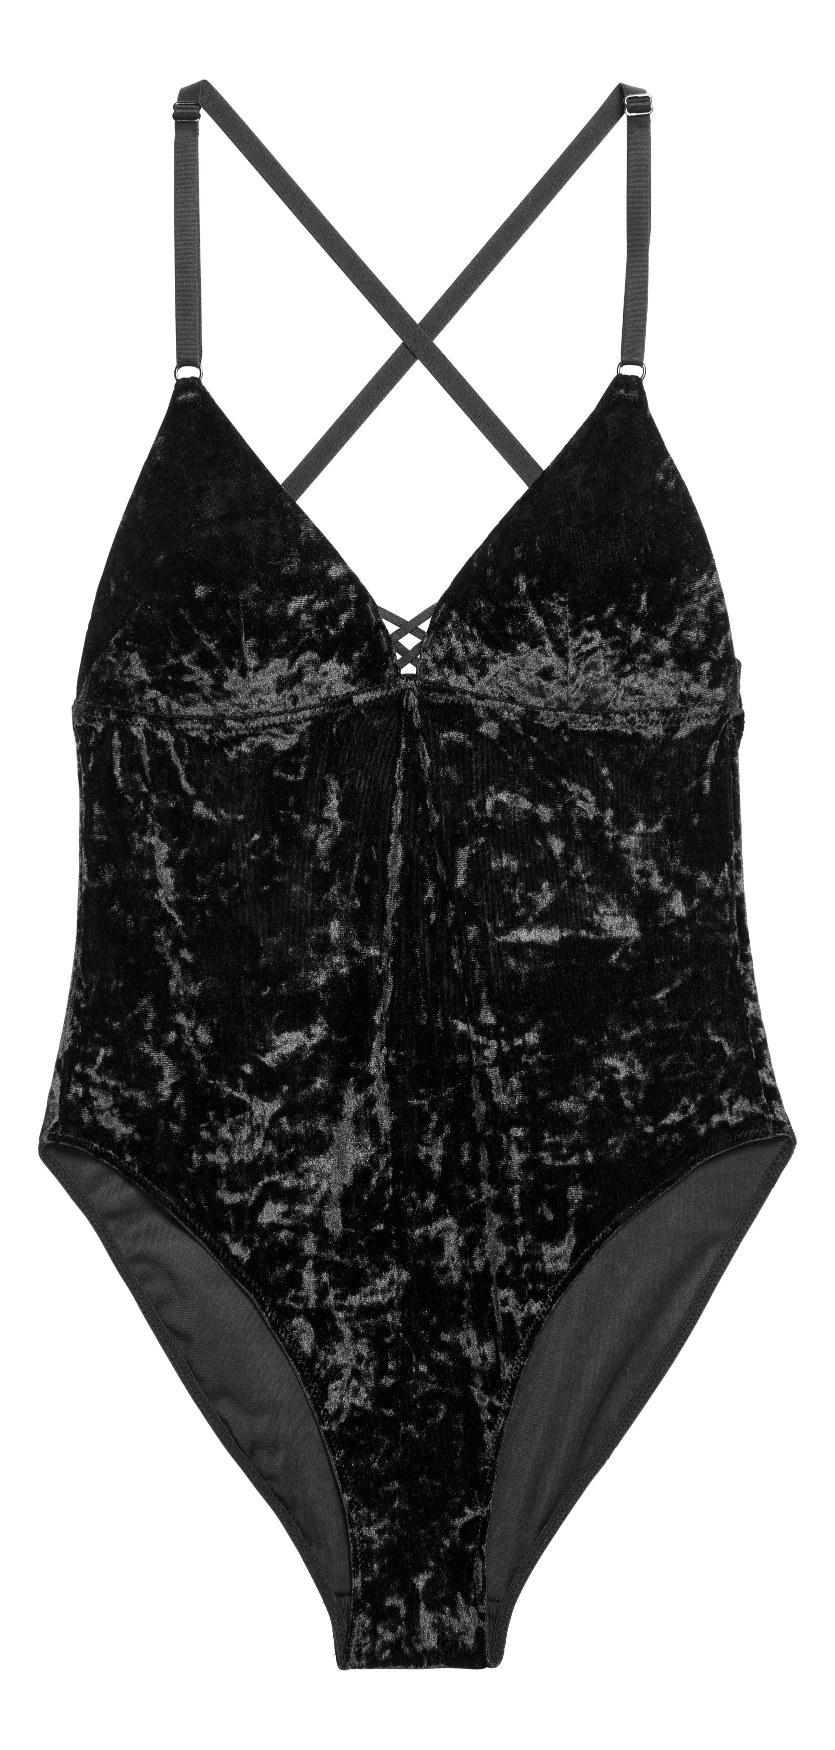

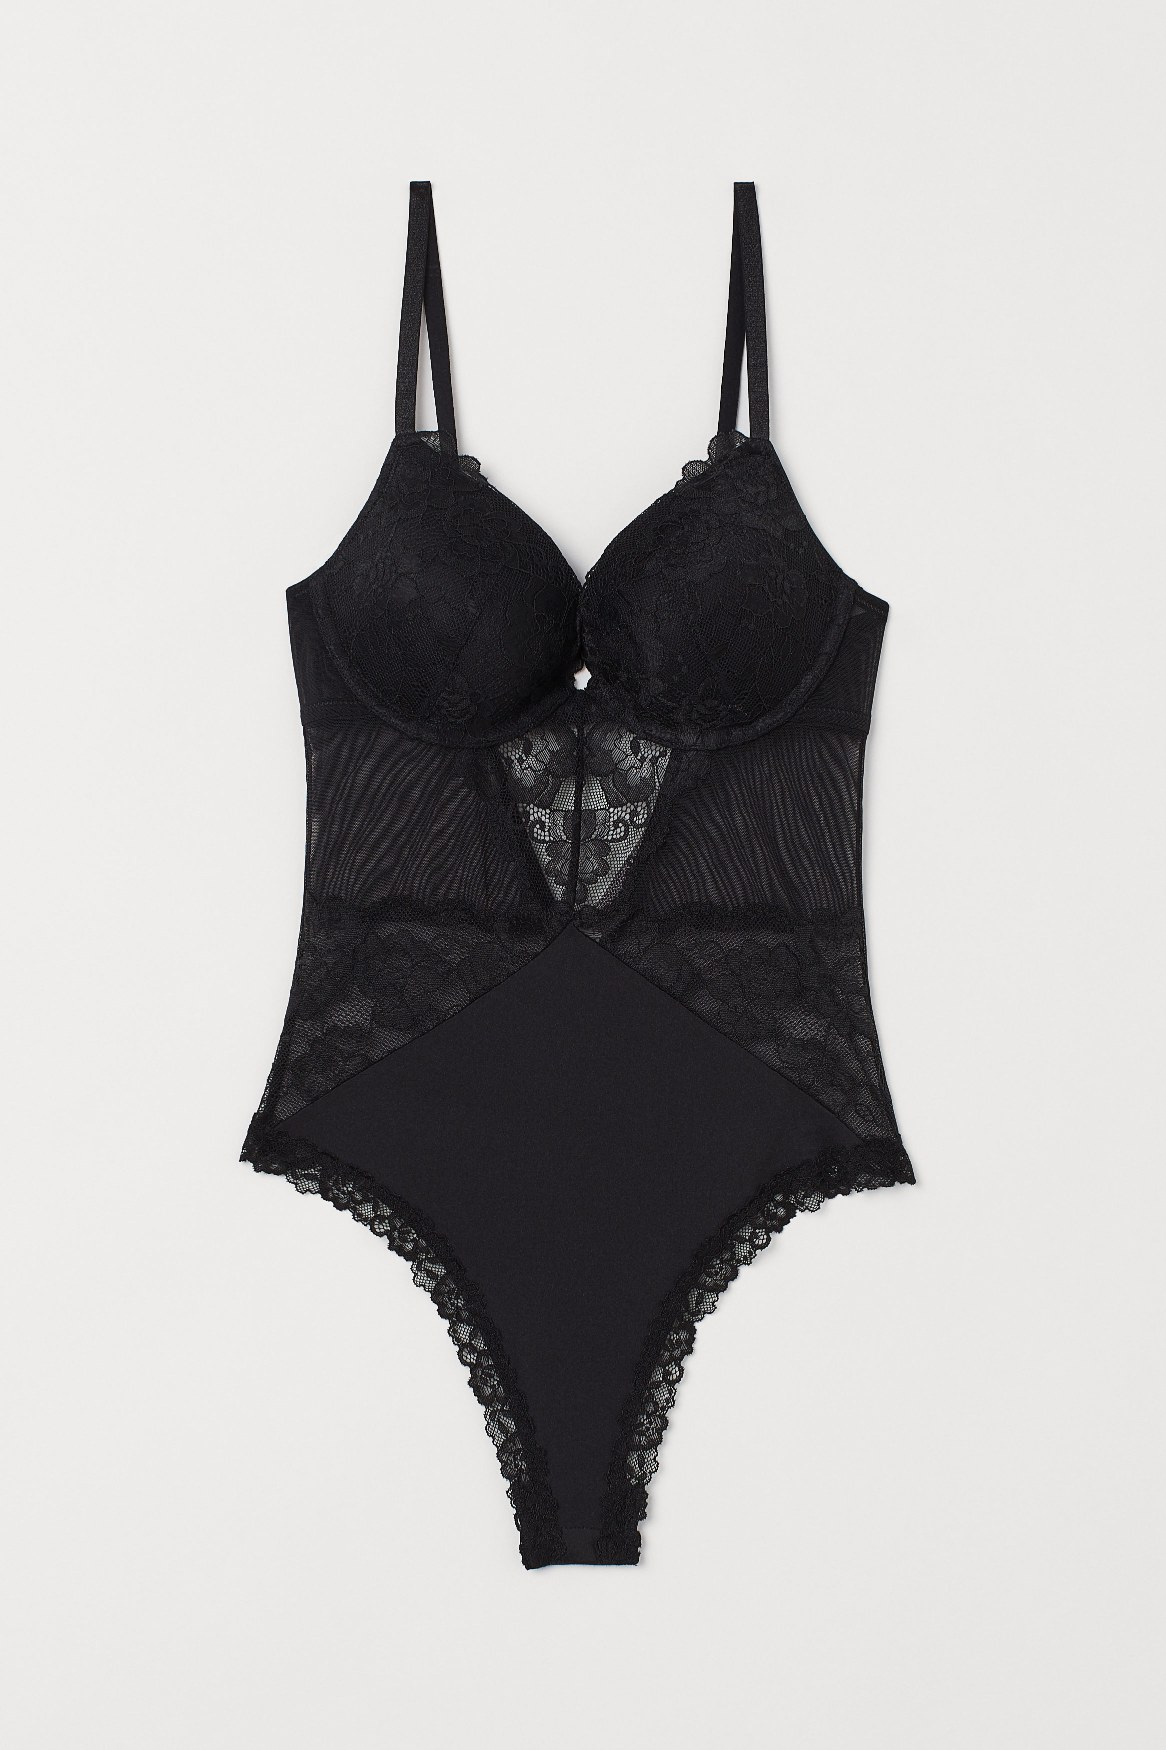

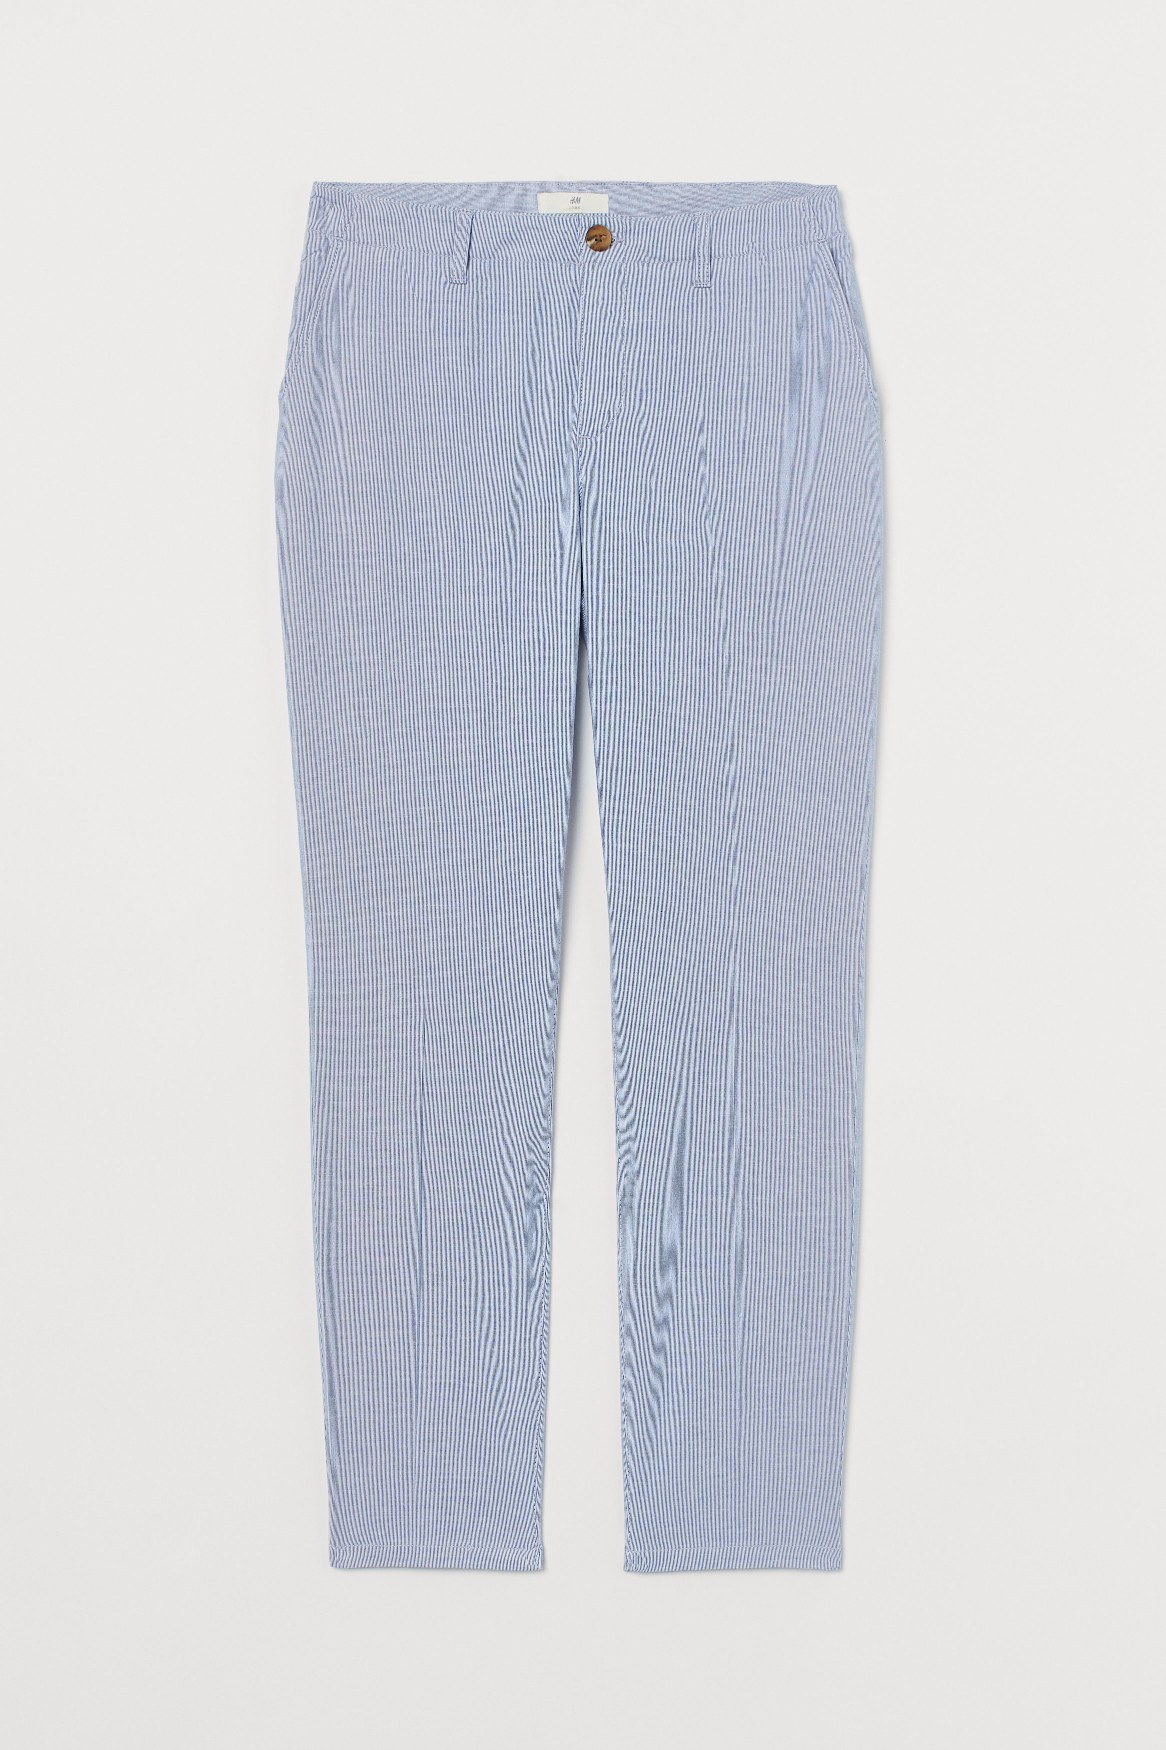

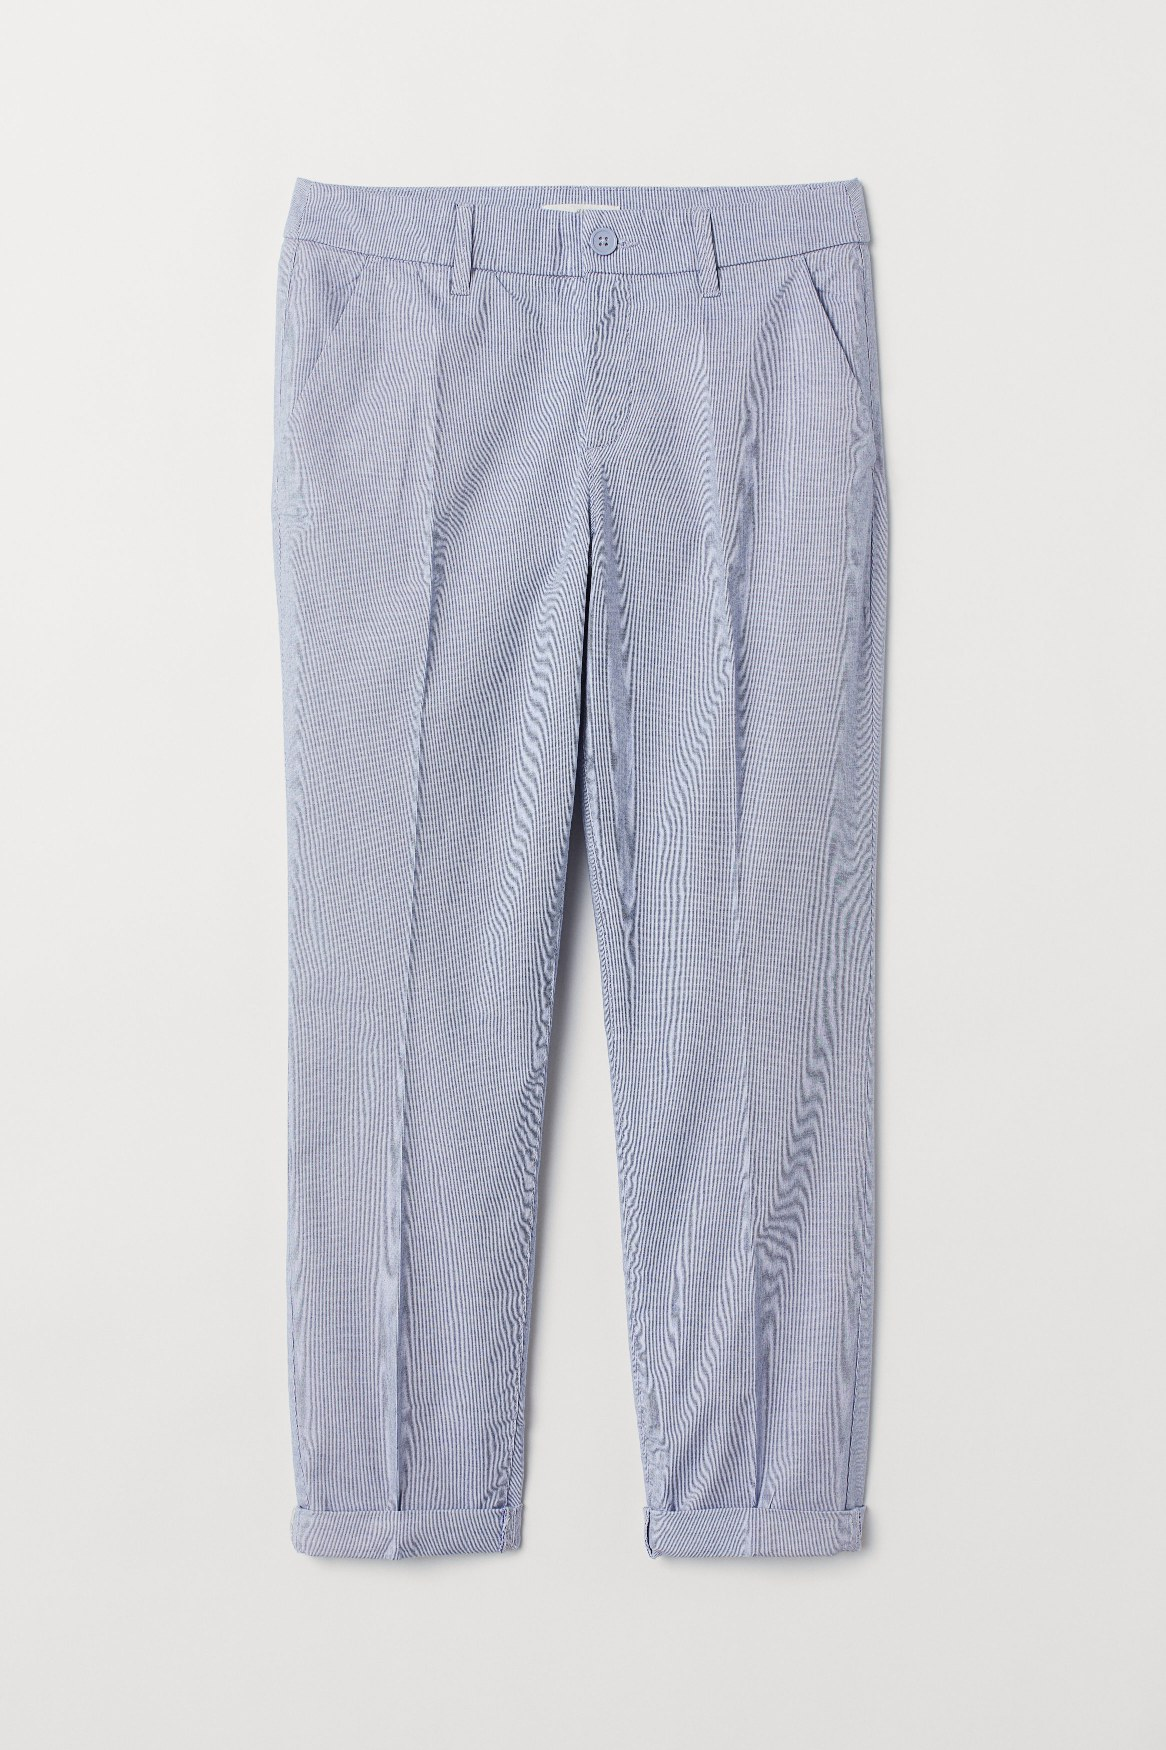

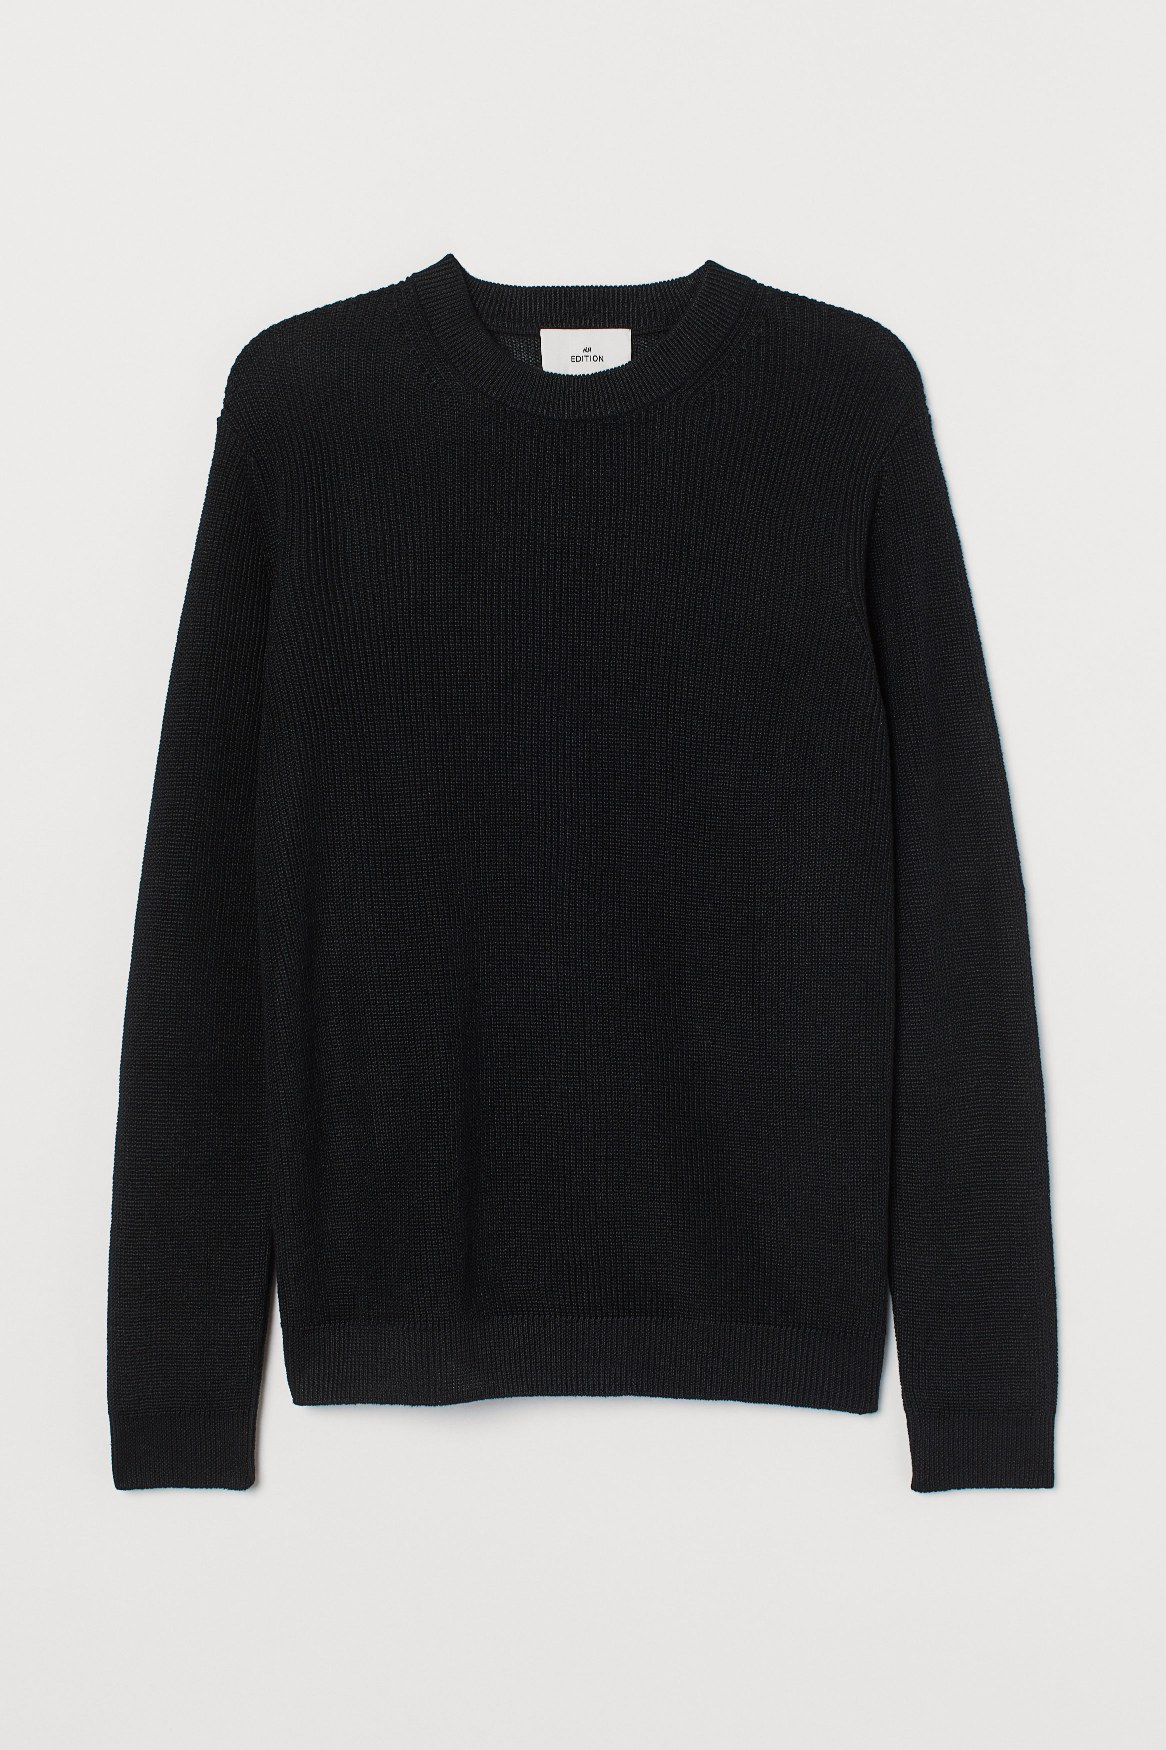

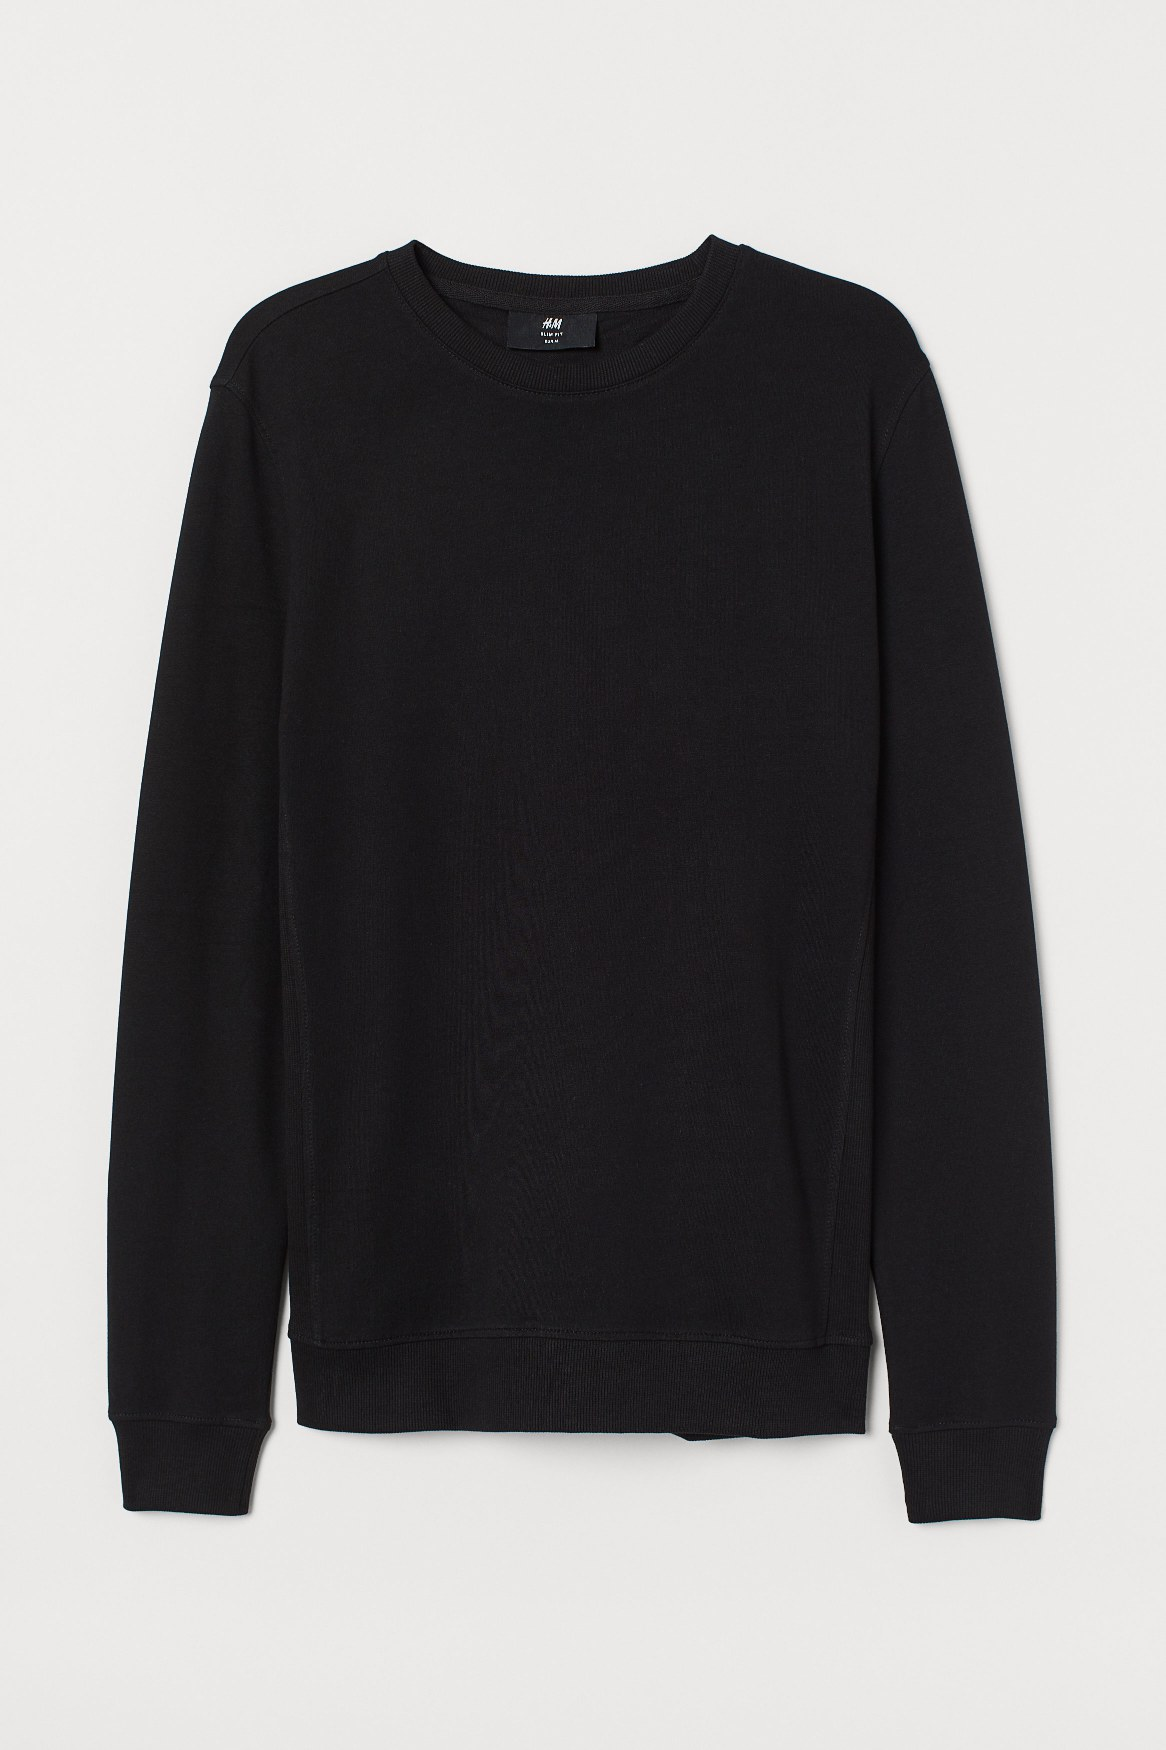

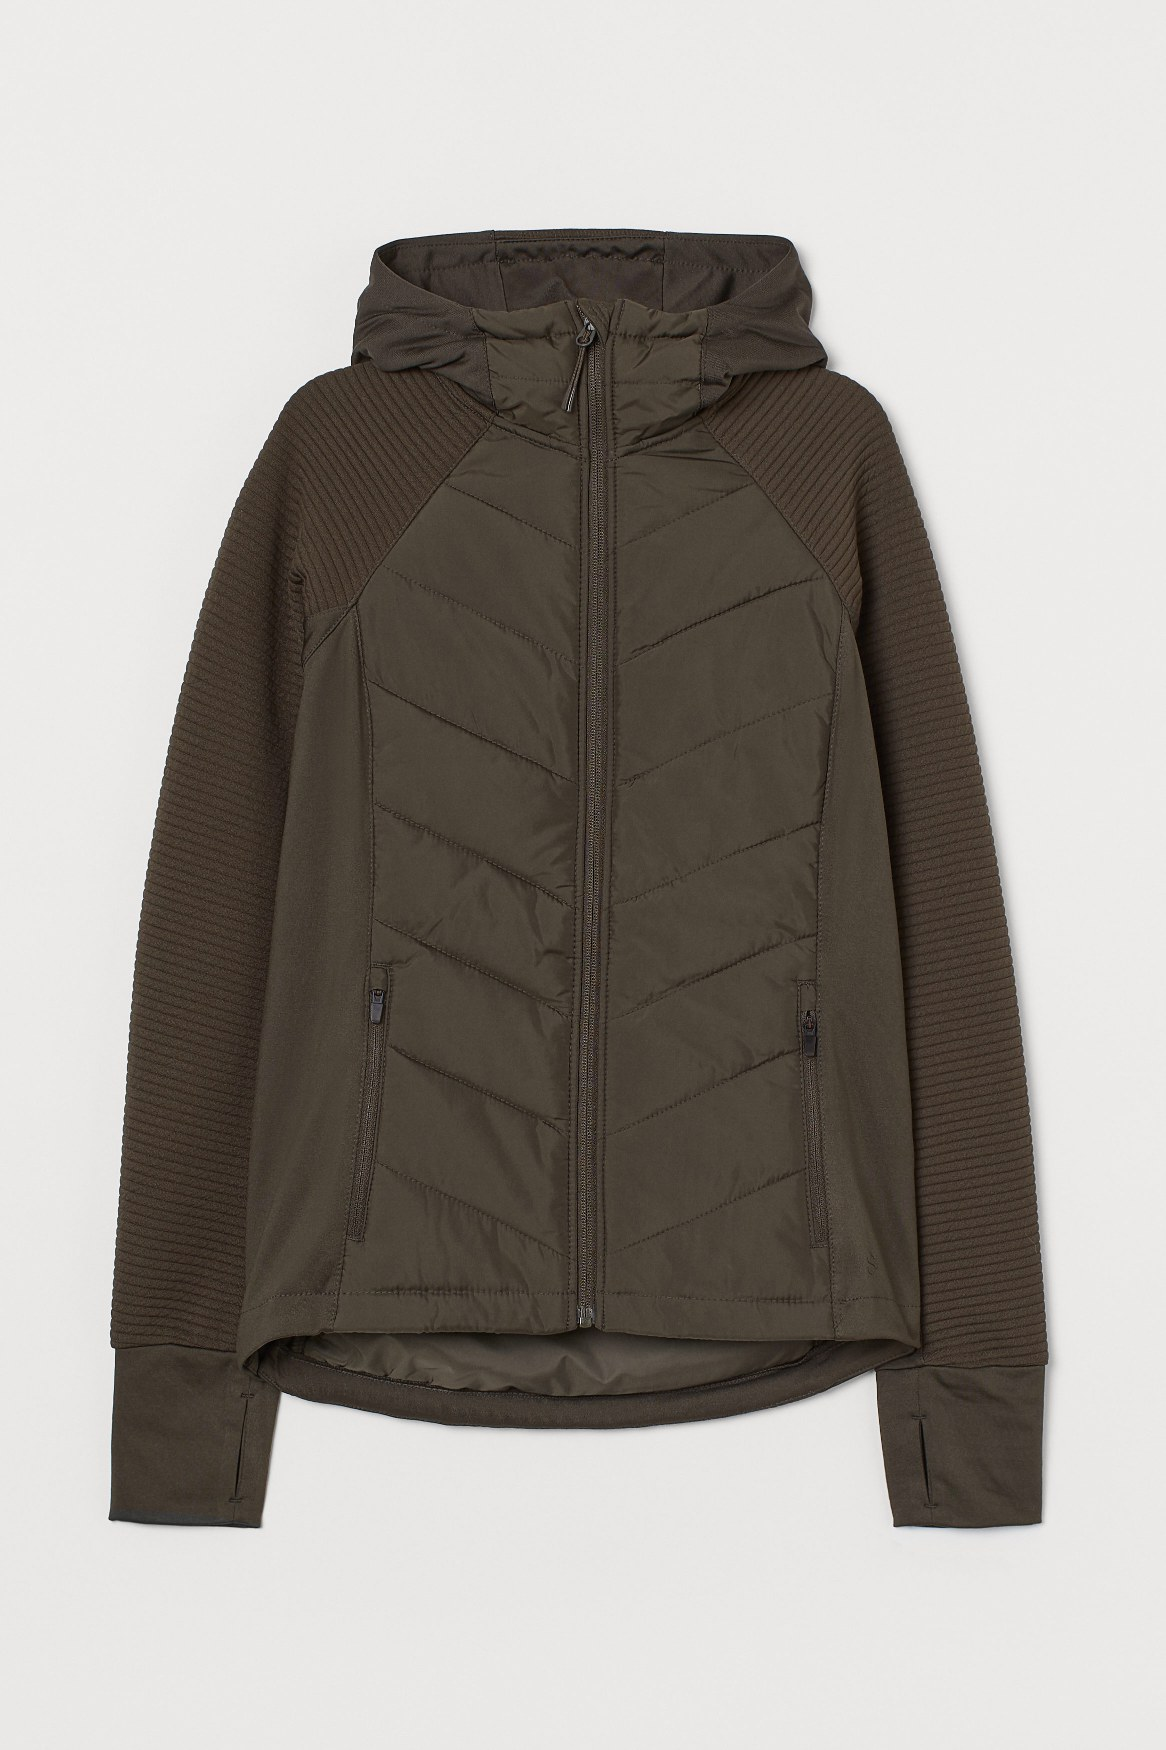

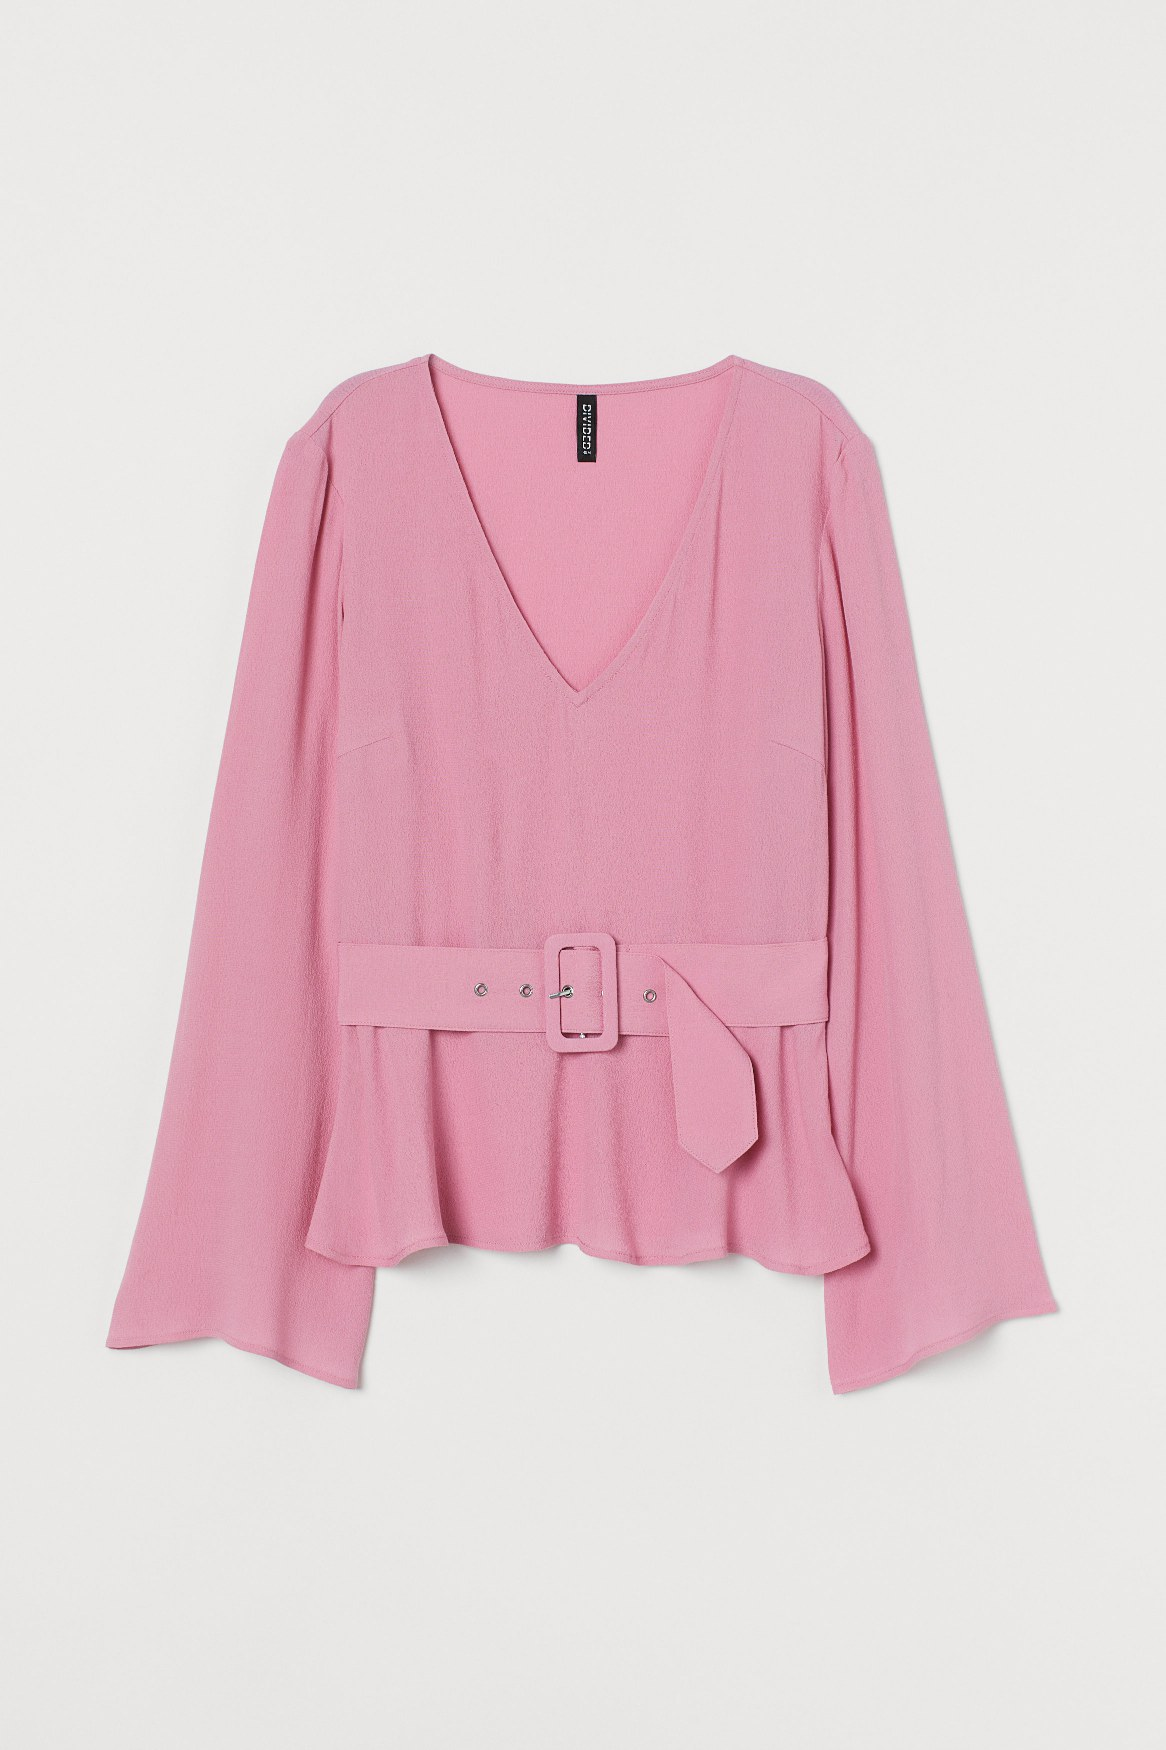

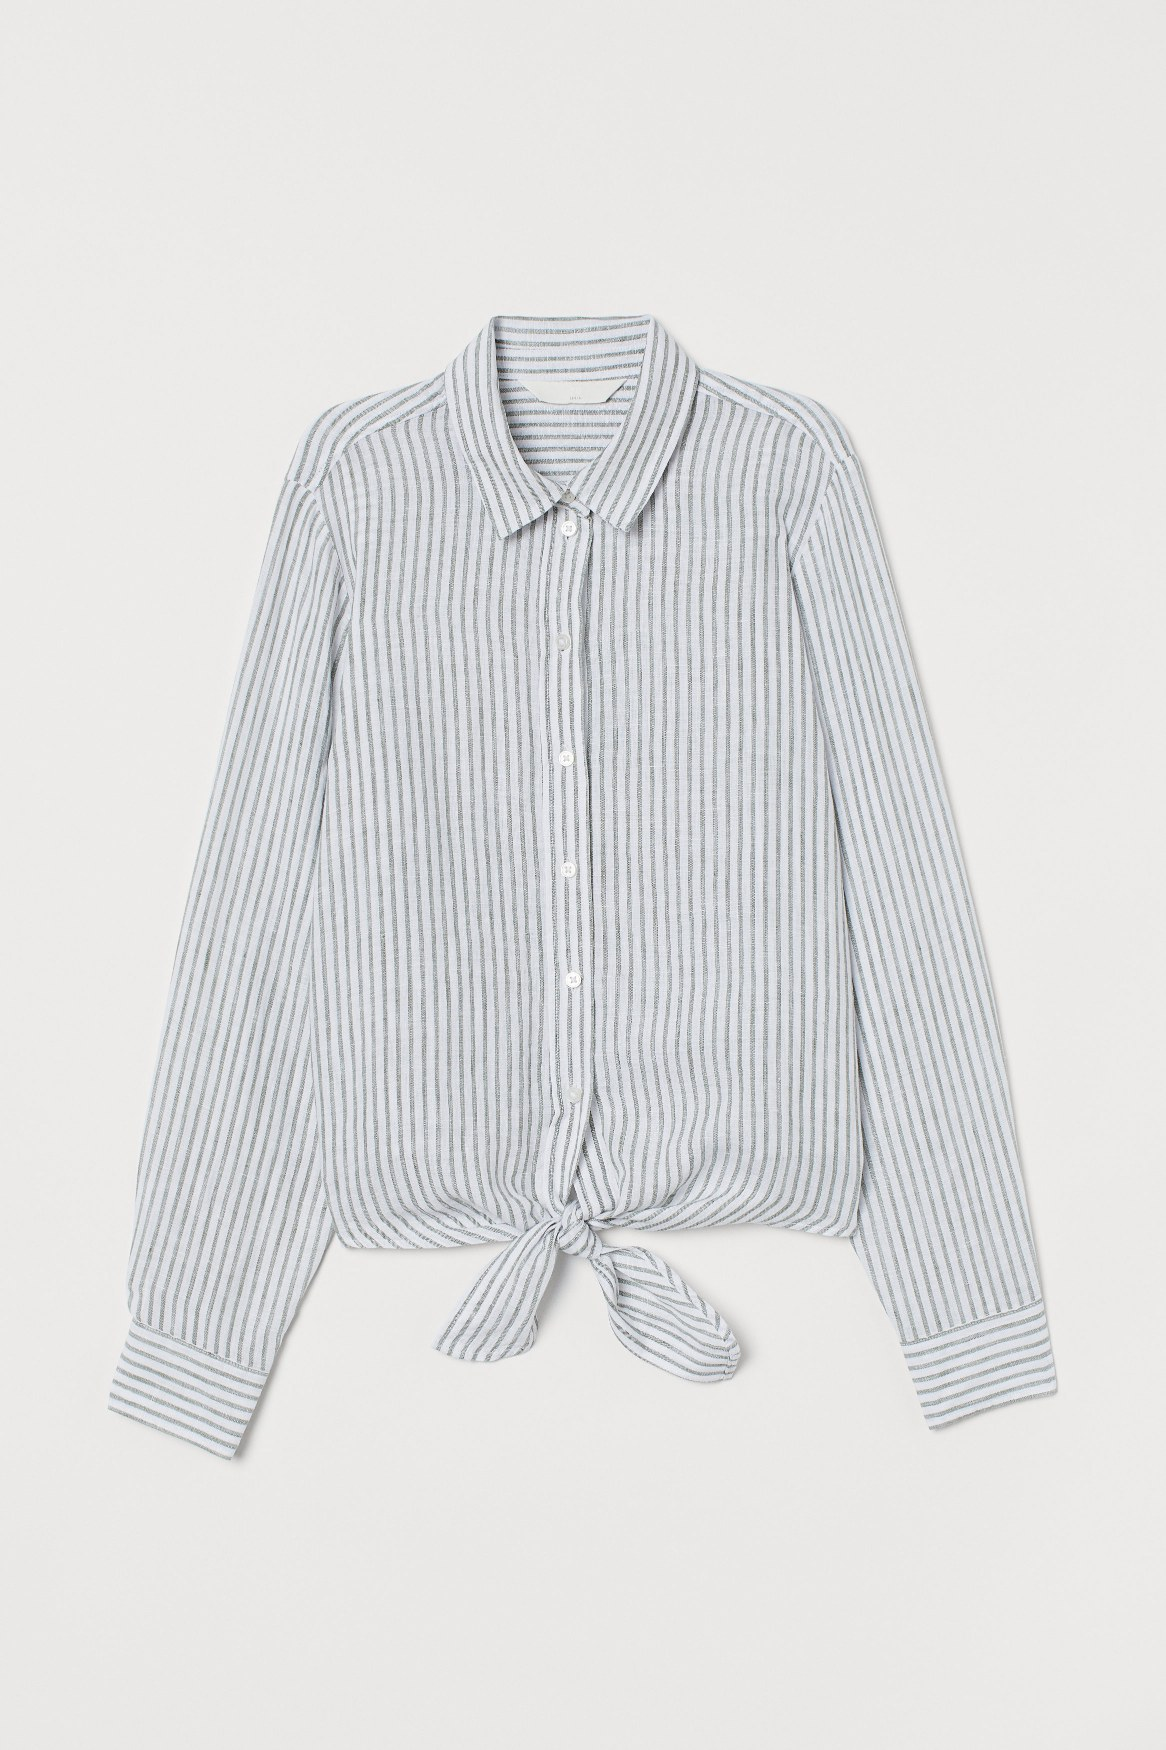

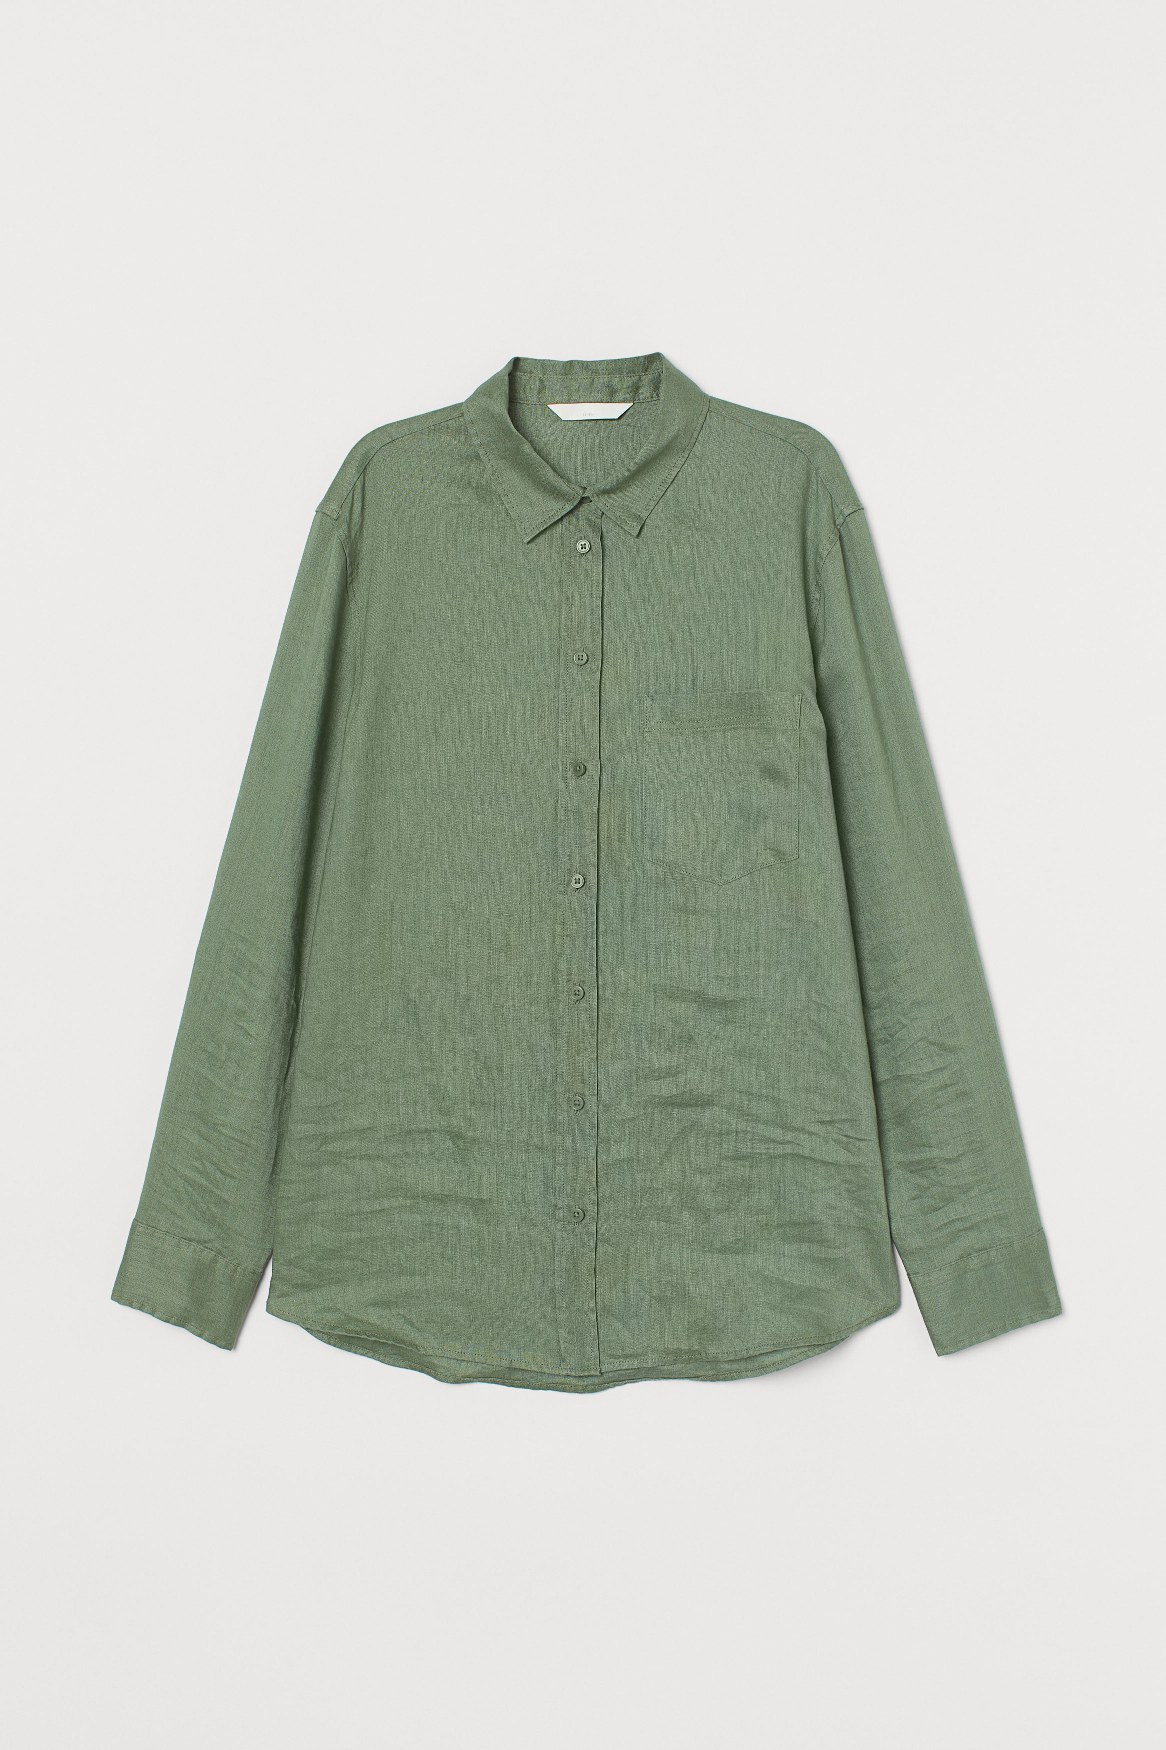

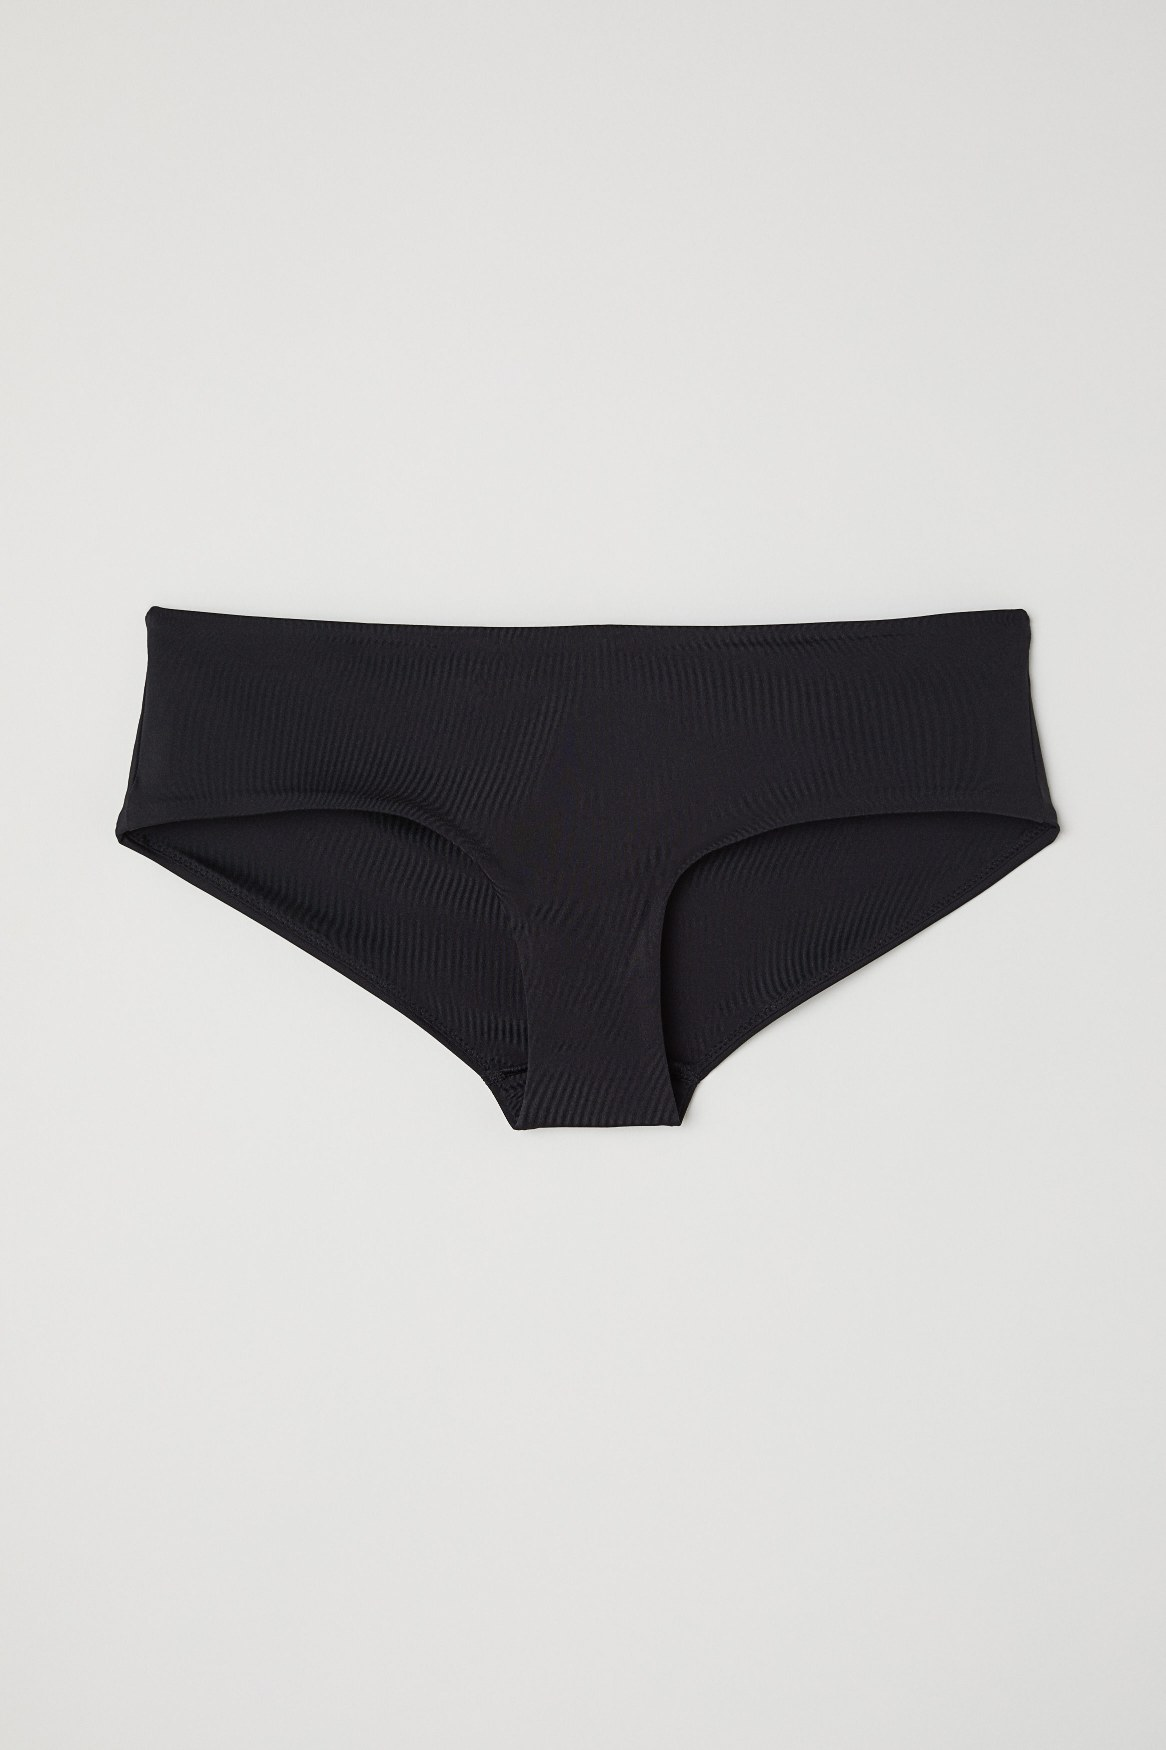

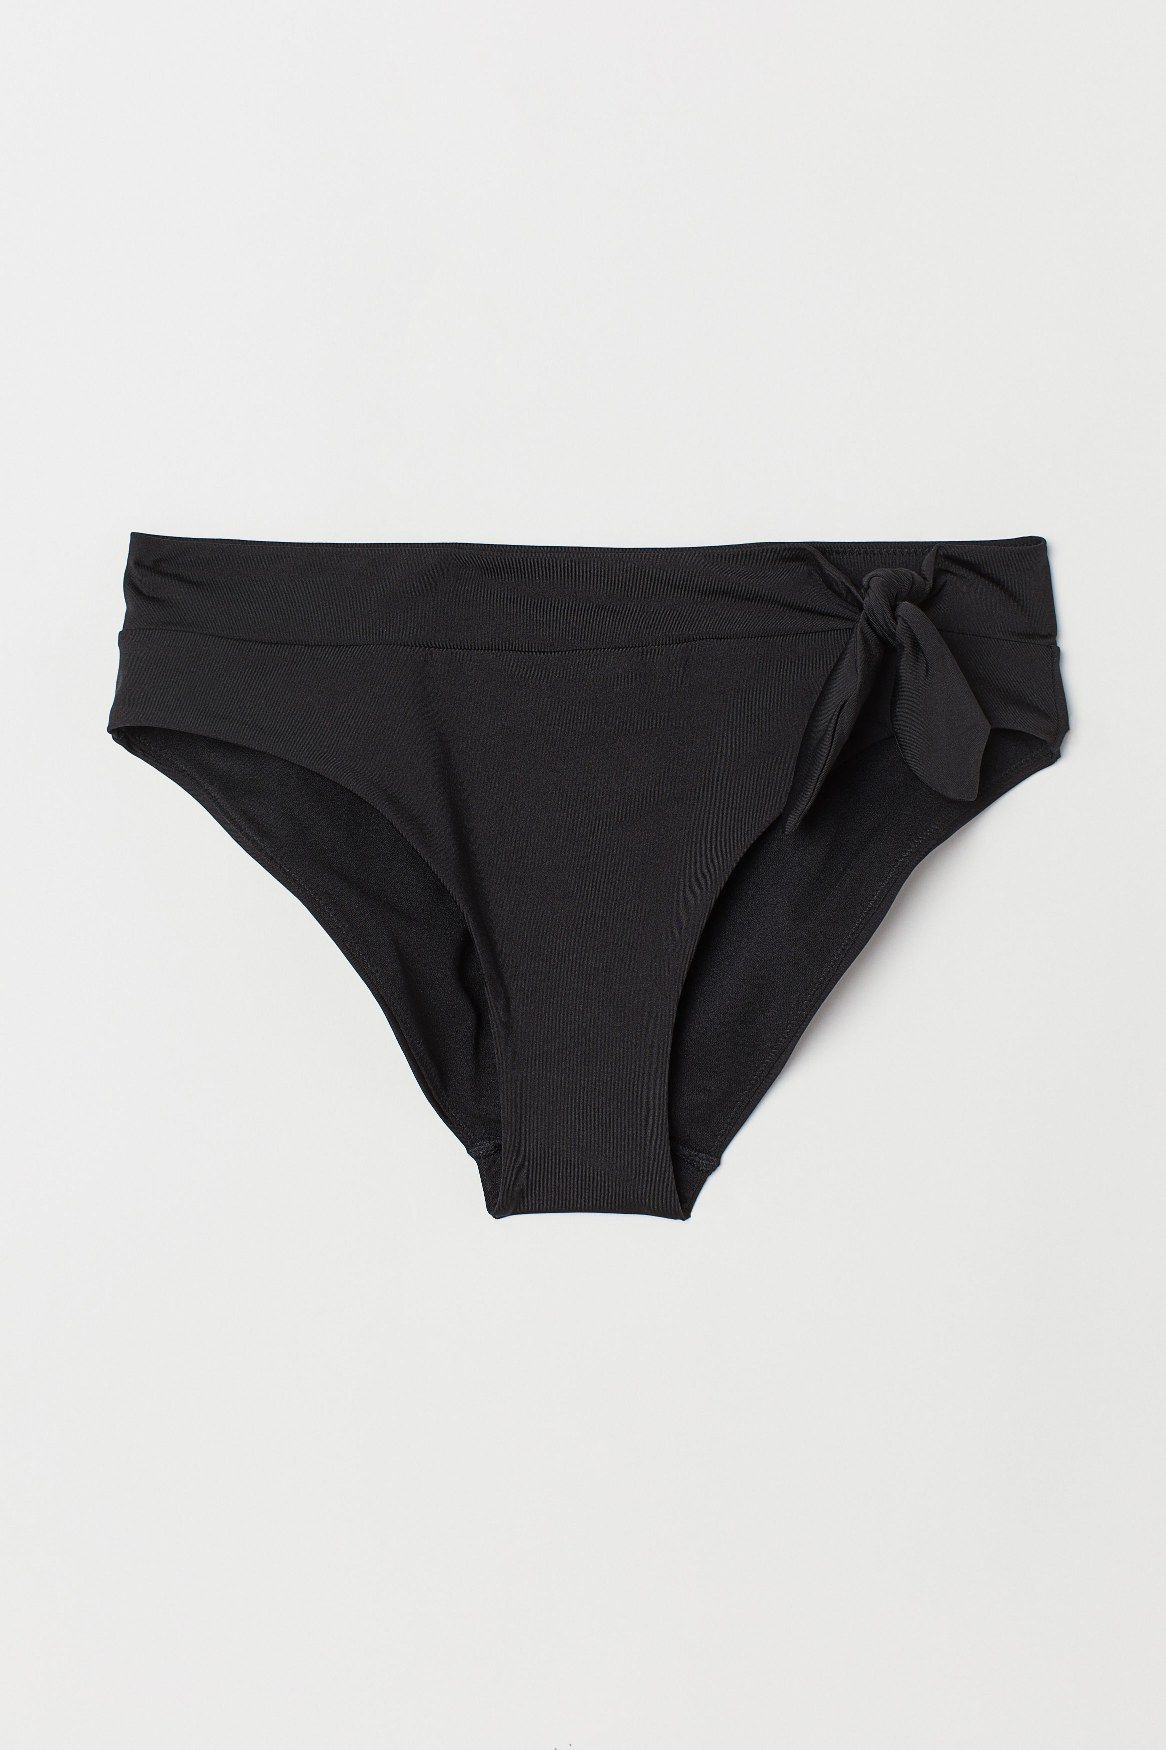

In [18]:
def display_articles(articles):
    for article_id in articles:
        filename = dataset.tree.image(article_id)
        display(Image(filename))

display_articles(recommendations)

In [31]:
def recommender(customers):
    """
    customers: list
        customer_id from the group of customer for which the recommendation is needed
    """
    df = pd.DataFrame(columns=['prediction'], index=customers)
    for c in customers:
        recommendations = recommender_by_customer(c)
        df.loc[c] = {'prediction': ' '.join(recommendations)}
    df = df.reset_index().rename(columns={'index':'customer_id'})

    #     output_file = open('months.txt', 'w')
    #     output_file.write(' '.join(recommendations))
    #     output_file.close()
    return df

    
    
results = recommender(customer_ids[:3])
results.head()

,customer_id,prediction
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0577725002 0914404001 0750424014 0690935006 08...
1,00007d2de826758b65a93dd24ce629ed66842531df6699...,0647483001 0312878001 0551462014 0710676001 07...
2,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,0695632015 0693387002 0587229001 0588592001 07...
